# **MA544**
## Academic Paper Ranking and Recommendations



1.   API
2.   Data Preprocessing
3.   Data Analysis
4.   Model
5.   Final Results



# Section 1

## API

In [ ]:
#@title Load Kaggle API (Enter kaggle API key) { display-mode: "form" }
!pip install -q kaggle

from google.colab import files

files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#@title Download arXiv Dataset { vertical-output: false }
!kaggle datasets download Cornell-University/arxiv
!unzip arxiv.zip -d arxiv-dataset

100% 1.10G/1.10G [00:29<00:00, 35.6MB/s]
100% 1.10G/1.10G [00:29<00:00, 40.3MB/s]
Archive:  arxiv.zip
  inflating: arxiv-dataset/arxiv-metadata-oai-snapshot.json  


In [ ]:
#check if got json

!ls arxiv-dataset

arxiv-metadata-oai-snapshot.json


In [ ]:
#@title Python Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

### Dataset

In [ ]:
'''
arVix dataset, takes tags needed from metadata. call given categories of interest (instead of calling )
'''
class ArVixDataset:
  def __init__(self, file_path, tags):
    self.file_path = file_path
    self.tags = tags

  def __call__(self, categories):
    raw_data = {tag: [] for tag in self.tags}
    categories = [category.lower() for category in categories]
    with open(self.file_path, 'r') as f:
      for line in f:
        d = json.loads(line)
        if d["categories"].lower() in categories:
          for key, value in raw_data.items():
            raw_data[key] += [d[key]]

    return pd.DataFrame(raw_data)

In [ ]:
arvix = ArVixDataset("arxiv-dataset/arxiv-metadata-oai-snapshot.json", ["id", "submitter", "authors", "title", "categories", "abstract", "update_date"])
arvix_dataset = arvix(["hep-ph"])

In [ ]:
arvix_dataset

,id,submitter,authors,title,categories,abstract,update_date
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,2008-11-26
1,0704.0016,Li Tong,"Chao-Hsi Chang, Tong Li, Xue-Qian Li and Yu-Mi...",Lifetime of doubly charmed baryons,hep-ph,"In this work, we evaluate the lifetimes of t...",2008-12-18
2,0704.0029,Weizhen Deng,"Zhan Shu, Xiao-Lin Chen and Wei-Zhen Deng",Understanding the Flavor Symmetry Breaking and...,hep-ph,"In $\XQM$, a quark can emit Goldstone bosons...",2010-04-23
3,0704.0031,Valery M. Biryukov,"V. M. Biryukov (Serpukhov, IHEP)",Crystal channeling of LHC forward protons with...,hep-ph,"We show that crystal can trap a broad (x, x'...",2008-11-26
4,0704.0032,Andreu Esteban-Pretel,"A. Esteban-Pretel, R. Tom\`as and J. W. F. Valle",Probing non-standard neutrino interactions wit...,hep-ph,We analyze the possibility of probing non-st...,2008-11-26
...,...,...,...,...,...,...,...
78009,hep-ph/9912547,Martin McDermott,"M. McDermott, L. Frankfurt, V. Guzey, M. Strikman",Unitarity and the QCD-improved dipole picture,hep-ph,As a consequence of QCD factorization theore...,2011-09-13
78010,hep-ph/9912548,Juerg Gasser,J. Gasser,Chiral perturbation theory,hep-ph,I present an outline of chiral perturbation ...,2008-11-26
78011,hep-ph/9912549,Petre Golumbeanu,P. Golumbeanu and C. Rosenzweig,Escape of Superheated Upsilons from the Quark ...,hep-ph,The properties of heavy quark systems change...,2007-05-23
78012,hep-ph/9912551,Thomas Teubner,"A.D. Martin, M.G. Ryskin and T. Teubner",Q^2 dependence of diffractive vector meson ele...,hep-ph,We give a general formula for the cross sect...,2008-11-26


In [ ]:
arvix_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78014 entries, 0 to 78013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           78014 non-null  object
 1   submitter    74402 non-null  object
 2   authors      78014 non-null  object
 3   title        78014 non-null  object
 4   categories   78014 non-null  object
 5   abstract     78014 non-null  object
 6   update_date  78014 non-null  object
dtypes: object(7)
memory usage: 4.2+ MB


In [ ]:
#convert date from string to datetime
arvix_dataset["update_date"] = pd.to_datetime(arvix_dataset["update_date"])

In [ ]:
arvix_dataset.sort_values(by='update_date')

,id,submitter,authors,title,categories,abstract,update_date
78013,hep-ph/9912553,Neil Russell,Neil Russell,Bounding CPT- and Lorentz-Violating Parameters...,hep-ph,A general theoretical framework that incorpo...,2007-05-23
43498,hep-ph/0111257,Honggong Wu,H. G. Wu,Fieldbus Device Drivers for Accelerator Contro...,hep-ph,In order to interface the DESY fieldbus adap...,2007-05-23
58467,hep-ph/0611044,Redamy Perez Ramos,Redamy Perez Ramos,"Hadronic distributions and correlations at ""sm...",hep-ph,We exactely calculate the inclusive transver...,2007-05-23
43499,hep-ph/0111258,J. F. de Troconiz,J. F. de Troc\'oniz and F. J. Yndur\'ain,Precision Determination of the Muon $g_{\mu}-2...,hep-ph,We present a summary of the results of two r...,2007-05-23
43505,hep-ph/0111265,Helmut Satz,H. Satz,Matter & More in Nuclear Collisions,hep-ph,The aim of high energy nuclear collisions is...,2007-05-23
...,...,...,...,...,...,...,...
37746,2211.11510,Hesham El Faham,Hesham El Faham,Complete study of four top quark production at...,hep-ph,We present a study of four top quark product...,2022-11-24
37764,2211.13013,Anil Thapa,"Julian Heeck, Jan Heisig, Anil Thapa",Dark matter and radiative neutrino masses in c...,hep-ph,The scotogenic model generates Majorana neut...,2022-11-24
37659,2211.06270,Dmitry Gorbunov,"Dmitry Gorbunov, Dmitry Kalashnikov",Probing light exotics from a hidden sector at ...,hep-ph,Future $c$-$\tau$ factories are natural plac...,2022-11-24
36537,2205.03617,Seokhoon Yun,"Eung Jin Chun, Seokhoon Yun",Particle dispersion in the classical vector da...,hep-ph,Interactions with a background medium modify...,2022-11-24


# Section 2

## Data Preprocessing

In [ ]:
def clean_abstract(text):
  '''
  Returns cleaned abstract string for preparation of NLP analysis
  Handles:
   - newlines
   - latex math
   - extra whitespaces
   - punctuation
   - drop single letters
   - lowercase
   - stopwords
  '''
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'(\$+)(?:(?!\1)[\s\S])*\1', ' ', text)
  text = re.sub(r'[^\w\s]', ' ', text)
  text = text.split(' ')
  text = [word.lower() for word in text if len(word) > 1]

  stop_words = ["ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", "do", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", "s", "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can", "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself", "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by", "doing", "it", "how", "further", "was", "here", "than"]

  text = [word for word in text if word not in stop_words]

  return text

#examples
for i in range(3):
  print(f"\nAbstract #{i}:\n")

  print(arvix_dataset.iloc[i]["abstract"])
  print("\n")

  print(clean_abstract(arvix_dataset.iloc[i]["abstract"]))


Abstract #0:

  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.




# Section 3

## Data Analysis

In [ ]:
#Create document list-of-list
arxiv_documents = [clean_abstract(document) for document in list(arvix_dataset['abstract'])]

In [ ]:
avg_unq_words = [len(set(doc)) for doc in arxiv_documents]
avg_words = [len(doc) for doc in arxiv_documents]
avg_unq_words_ratio = [len(set(doc))/len(doc) for doc in arxiv_documents]
total_unq_words = [item for sublist in arxiv_documents for item in sublist]

print(f"Abstract info:\n Total Words: {len(total_unq_words)}\n Avg. Words per Doc: {1/len(arxiv_documents)*sum(avg_words)}\n Avg. Unique Words per Doc: {1/len(arxiv_documents)*sum(avg_unq_words)}\n Avg. Unique Words per Doc Ratio: {1/len(arxiv_documents)*sum(avg_unq_words_ratio)}\n\n Total Unique Words: {len(set(total_unq_words))}\n Total Unique Word Ratio: {len(set(total_unq_words))/len(total_unq_words)}")

Abstract info:
 Total Words: 4928821
 Avg. Words per Doc: 63.178673058681774
 Avg. Unique Words per Doc: 50.06353987745789
 Avg. Unique Words per Doc Ratio: 0.8224857241828534

 Total Unique Words: 38563
 Total Unique Word Ratio: 0.007823980623358


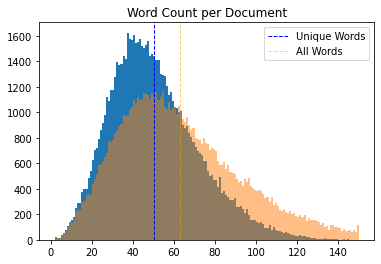

In [ ]:
bin_width = 1
plt.hist(avg_unq_words, bins=np.arange(min(avg_unq_words), max(avg_unq_words) + bin_width, bin_width))
plt.axvline(1/len(arxiv_documents)*sum(avg_unq_words), color='b', linestyle='dashed', linewidth=1)

plt.hist(avg_words, bins=np.arange(min(avg_unq_words), max(avg_unq_words) + bin_width, bin_width), alpha=0.5)
plt.axvline(1/len(arxiv_documents)*sum(avg_words), color='orange', linestyle='dashed', linewidth=1, alpha=0.5)
plt.title("Word Count per Document")
plt.legend(['Unique Words', 'All Words'])
plt.show()

From the above observations, both distributions are similar in skewness, with the unique words having a more centered distribution around 40~.



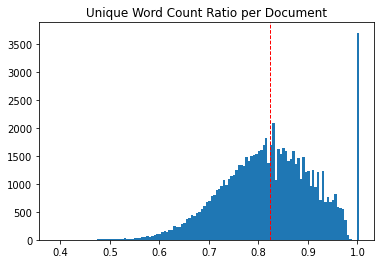

In [ ]:
bin_width = 0.005
plt.hist(avg_unq_words_ratio, bins=np.arange(min(avg_unq_words_ratio), max(avg_unq_words_ratio) + bin_width, bin_width))
plt.axvline(1/len(arxiv_documents)*sum(avg_unq_words_ratio), color='r', linestyle='dashed', linewidth=1)
plt.title("Unique Word Count Ratio per Document")
plt.show()

In [ ]:
#analysis on documents with unique world count ratio = 1

# Section 4
## Model

In [ ]:
class TFIDF:
  def __init__(self):
    self.vectorizer = CountVectorizer()

  def BOW(self, documents):
    #Returns bag-of-words of document list and the feature names
    bow = self.vectorizer.fit_transform(documents)
    return bow.toarray(), self.vectorizer.get_feature_names()

  def TF(self, bow):
    #Calculate term frequency for each document, word/word count in document
    return np.apply_along_axis(lambda x: x/np.sum(x), 1, bow)

  def IDF(self, bow):
    # Calculates IDF
    N = bow.shape[0]

    # Check if word exists in document, then convert to int, and sum through all matrices to get doc. frequency
    df = sum((bow[i]>0).astype(int) for i in range(N))

    return np.log(N/df)

  def __call__(self, documents):
    #Runs whole TDIDF process
    bow, feature_names = self.BOW(documents)
    tf = self.TF(bow)
    idf = self.IDF(bow)

    return {"tfidf": tf*idf, "features": feature_names, "bow": bow}

In [ ]:
TFIDF_model = TFIDF()

out = TFIDF_model(arxiv_documents[:100])

In [ ]:
out["tfidf"].shape

# Section 5
## Query

In [ ]:

def query(topic="all", author="all", publication="all", daterange="all", relevance="all", field="all"):
  print(topic, author, publication, daterange, relevance, field)

In [ ]:
query()
